In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.knn import *
from lib.foolbox_model import *
from lib.utils import *

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [40]:
exp_id = 0

model_name = 'train_mnist_exp%d.h5' % exp_id
net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=1000)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'adv_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel()
# # basic_net = BasicModelV2()
# config = {'epsilon': 0.3,
#               'num_steps': 40,
#               'step_size': 0.01,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDModel(basic_net, config)

In [42]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
# net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [8]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [7]:
y_pred = net(x_test.to(device))
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9833

In [43]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu3']
# layers = ['fc']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# with torch.no_grad():
#     dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#                 k=75, num_classes=10)
#     y_pred = dknn.classify(x_test)
    
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [11]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.98


(array([ 949., 1033.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8018.]),
 array([0.016 , 0.1144, 0.2128, 0.3112, 0.4096, 0.508 , 0.6064, 0.7048,
        0.8032, 0.9016, 1.    ]),
 <a list of 10 Patch objects>)

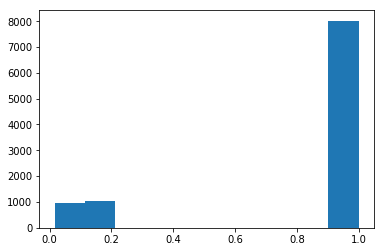

In [12]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [13]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

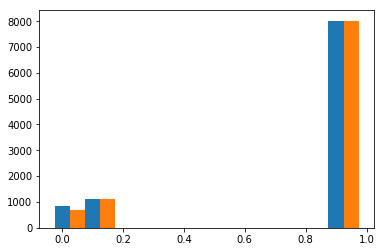

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [15]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.79532164, 0.98402839,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.99912696])

In [44]:
dknn_fb = DkNNFoolboxModel(dknn, (0, 1), 1, preprocessing=(0, 1))

In [45]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.BoundaryAttack(
    model=dknn_fb, criterion=criterion, distance=distance)

In [56]:
attack_params = {
    'iterations': 10000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 100,
    'spherical_step': 0.05,
    'source_step': 0.05,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=True, **attack_params)

Neither starting_point nor initialization_attack given. Falling back to BlendedUniformNoiseAttack for initialization.
Initial spherical_step = 0.05, source_step = 0.05
Using 4 threads to create random numbers
Step 0: 8.71503e-02, stepsizes = 5.0e-02/5.0e-02: 
  Success rate too low, decreasing source step:  0.57 ( 75), 0.00 (30)
  Boundary too linear, increasing steps:     0.57 (100), 0.00 (14)
  Success rate too low, decreasing source step:  0.54 ( 50), 0.00 (30)
  Boundary too linear, increasing steps:     0.60 (100), 0.00 (30)
  Success rate too low, decreasing source step:  0.60 (100), 0.00 (30)
Step 100: 8.14371e-02, stepsizes = 1.1e-01/3.3e-02:  (took 6.76223 seconds)
Initializing generation and prediction time measurements. This can take a few seconds.
During initialization, a better adversarial has been found. Continuing from there.
Estimating optimal batch size
Time since beginning: 554.59922
   1.1% for generation (6.25549)
   16.3% for spherical prediction (90.54015)
   70.2

  Boundary too non-linear, decreasing steps: 0.16 (100), 0.15 (27)
  Success rate too low, decreasing source step:  0.28 ( 25), 0.07 (30)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0.00 ( 8)
  Success rate too low, decreasing source step:  0.24 (100), 0.07 (30)
Step 300: 2.22285e-02, stepsizes = 5.0e-02/2.9e-03:  (took 0.56806 seconds)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.14 ( 7)
  Success rate too high, increasing source step: 0.50 (100), 0.53 (30)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.12 (17)
Step 400: 1.60728e-02, stepsizes = 2.2e-02/2.0e-03: d. reduced by 0.39% (6.2898e-05) (took 0.63767 seconds)
Estimating optimal batch size
Time since beginning: 665.30181
   1.3% for generation (8.47660)
   15.1% for spherical prediction (100.38279)
   72.1% for prediction (479.77963)
   0.0% for hyperparameter update (0.05073)
   11.5% for the rest (76.61206)
current estimate of the time to generate a candidate depending on the batch size:

Step 900: 8.58667e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.6217e-06) (took 0.44916 seconds)
  Boundary too non-linear, decreasing steps: 0.10 (100), 0.57 (30)
  Success rate too high, increasing source step: 0.10 (100), 0.57 (30)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0.05 (22)
Step 1000: 8.20488e-03, stepsizes = 6.6e-03/2.6e-04:  (took 0.46306 seconds)
  Boundary too non-linear, decreasing steps: 0.14 (100), 0.17 (30)
  Success rate too low, decreasing source step:  0.14 (100), 0.17 (30)
Step 1100: 8.00269e-03, stepsizes = 4.4e-03/1.1e-04: d. reduced by 0.02% (1.8279e-06) (took 0.64393 seconds)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.33 (30)
Step 1200: 7.85601e-03, stepsizes = 2.9e-03/7.6e-05: d. reduced by 0.02% (1.1963e-06) (took 0.58013 seconds)
  Boundary too linear, increasing steps:     0.65 (100), 0.73 (30)
  Success rate too high, increasing source step: 0.65 (100), 0.73 (30)
  Boundary too non-linear, decreasing steps: 0.19

  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
Step 2300: 7.61212e-03, stepsizes = 2.3e-05/2.3e-05:  (took 0.24838 seconds)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (25)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.08 (26)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.08 (26)
  Boundary too non-linear, decreasing steps: 0.02 (100), 0.07 (28)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.07 (28)
  Success rate too low, decreasing source step:  0.03 ( 75), 0.07 (30)
  Boundary too non-linear, decreasing steps: 0.03 (100), 0.00 ( 1)
  Boundary too non-linear, decreasing steps: 0.0

Step 2403: 7.61212e-03, stepsizes = 2.0e-09/4.0e-10: 
Looks like attack has converged after 2404 steps, 49 remaining
Step 2404: 7.61212e-03, stepsizes = 2.0e-09/4.0e-10: 
Looks like attack has converged after 2405 steps, 48 remaining
  Success rate too high, increasing source step: 0.20 (100), 0.53 (30)
Step 2405: 7.61212e-03, stepsizes = 2.0e-09/6.0e-10: 
Looks like attack has converged after 2406 steps, 47 remaining
  Boundary too non-linear, decreasing steps: 0.15 (100), -1.00 ( 0)
Step 2406: 7.61212e-03, stepsizes = 1.4e-09/4.0e-10: 
Looks like attack has converged after 2407 steps, 46 remaining
Step 2407: 7.61212e-03, stepsizes = 1.4e-09/4.0e-10: 
Looks like attack has converged after 2408 steps, 45 remaining
Step 2408: 7.61212e-03, stepsizes = 1.4e-09/4.0e-10: 
Looks like attack has converged after 2409 steps, 44 remaining
Step 2409: 7.61212e-03, stepsizes = 1.4e-09/4.0e-10: 
Looks like attack has converged after 2410 steps, 43 remaining
  Boundary too non-linear, decreasing step

In [57]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.0


In [58]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

2.4429293


In [59]:
dist = np.max(np.abs(x_adv - x_test[:num].numpy()), (1, 2, 3))
print(dist)

[0.38494432]


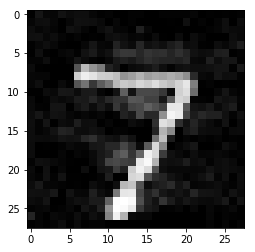

In [60]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')

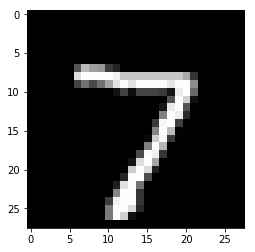

In [61]:
plt.imshow(x_test[0].numpy().reshape(28, 28), cmap='gray')

In [89]:
knn = KNNL2(x_train, y_train, x_valid, y_valid, k=75, num_classes=10)

In [90]:
knn_fb = DkNNFoolboxModel(knn, (0, 1), 1, preprocessing=(0, 1))

In [91]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.BoundaryAttack(
    model=knn_fb, criterion=criterion, distance=distance)

In [93]:
attack_params = {
    'iterations': 10000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 100,
    'spherical_step': 1.0,
    'source_step': 0.1,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=True, **attack_params)

Neither starting_point nor initialization_attack given. Falling back to BlendedUniformNoiseAttack for initialization.
Initial spherical_step = 1.00, source_step = 0.10
Using 4 threads to create random numbers
Step 0: 2.51014e-01, stepsizes = 1.0e+00/1.0e-01: 
  Boundary too non-linear, decreasing steps: 0.00 (100), -1.00 ( 0)
  Boundary too non-linear, decreasing steps: 0.00 (100), -1.00 ( 0)
Step 100: 1.38781e-01, stepsizes = 4.4e-01/4.4e-02:  (took 0.80455 seconds)
Initializing generation and prediction time measurements. This can take a few seconds.
During initialization, a better adversarial has been found. Continuing from there.
Estimating optimal batch size
Time since beginning: 192.98212
   4.1% for generation (7.81726)
   17.0% for spherical prediction (32.83595)
   64.7% for prediction (124.82559)
   0.0% for hyperparameter update (0.00618)
   14.2% for the rest (27.49714)
current estimate of the time to generate a candidate depending on the batch size:
[3.11849263e-03 1.29878

  Success rate too low, decreasing source step:  0.12 ( 50), 0.07 (30)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0.11 ( 9)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0.21 (24)
Step 300: 3.32159e-02, stepsizes = 5.9e-02/3.9e-03: d. reduced by 0.78% (2.6073e-04) (took 0.56737 seconds)
  Success rate too low, decreasing source step:  0.20 ( 75), 0.17 (30)
  Boundary too non-linear, decreasing steps: 0.16 (100), 1.00 ( 1)
  Boundary too non-linear, decreasing steps: 0.14 (100), 0.22 (23)
Step 400: 2.75217e-02, stepsizes = 2.6e-02/1.2e-03: d. reduced by 0.23% (6.3746e-05) (took 0.25705 seconds)
Estimating optimal batch size
Time since beginning: 276.01621
   3.6% for generation (10.06696)
   14.6% for spherical prediction (40.37381)
   70.6% for prediction (194.93326)
   0.0% for hyperparameter update (0.12338)
   11.1% for the rest (30.51880)
current estimate of the time to generate a candidate depending on the batch size:
[3.11849263e-03 1.29878521e-04 1.36057

  Success rate too low, decreasing source step:  0.21 ( 24), 0.13 (30)
  Boundary too non-linear, decreasing steps: 0.16 (100), 0.16 (25)
  Success rate too low, decreasing source step:  0.20 ( 25), 0.17 (30)
Step 700: 2.42028e-02, stepsizes = 3.4e-03/1.0e-04: d. reduced by 0.02% (4.9136e-06) (took 0.33337 seconds)
  Success rate too high, increasing source step: 0.46 (100), 0.53 (30)
  Boundary too non-linear, decreasing steps: 0.14 (100), 0.15 (13)
Step 800: 2.37960e-02, stepsizes = 2.3e-03/1.0e-04: d. reduced by 0.02% (4.8312e-06) (took 0.41077 seconds)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.27 (30)
Step 900: 2.35334e-02, stepsizes = 1.5e-03/6.8e-05:  (took 0.38240 seconds)
  Success rate too low, decreasing source step:  0.25 ( 97), 0.13 (30)
Step 1000: 2.33546e-02, stepsizes = 1.5e-03/4.5e-05: d. reduced by 0.01% (2.1073e-06) (took 0.28056 seconds)
Estimating optimal batch size
Time since beginning: 430.80211
   3.4% for generation (14.71553)
   12.5% for spher

  Boundary too non-linear, decreasing steps: 0.18 (100), 0.17 (30)
  Success rate too low, decreasing source step:  0.18 (100), 0.17 (30)
Step 1900: 2.29668e-02, stepsizes = 2.6e-05/7.8e-07: d. reduced by 0.00% (3.6003e-08) (took 0.22091 seconds)
  Success rate too high, increasing source step: 0.58 ( 55), 0.77 (30)
  Boundary too non-linear, decreasing steps: 0.16 (100), 0.31 (13)
Step 2000: 2.29647e-02, stepsizes = 1.8e-05/7.8e-07:  (took 0.39241 seconds)
  Boundary too non-linear, decreasing steps: 0.06 (100), 0.21 (19)
  Boundary too non-linear, decreasing steps: 0.10 (100), 0.23 (30)
Step 2100: 2.29639e-02, stepsizes = 7.8e-06/3.5e-07:  (took 0.47583 seconds)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.30 (30)
  Boundary too non-linear, decreasing steps: 0.08 (100), 0.23 (30)
Step 2200: 2.29633e-02, stepsizes = 3.5e-06/1.5e-07: d. reduced by 0.00% (7.1607e-09) (took 0.38019 seconds)
Estimating optimal batch size
Time since beginning: 721.17518
   3.2% for generation

Step 2345: 2.29633e-02, stepsizes = 1.8e-07/5.2e-08: 
Looks like attack has converged after 2346 steps, 92 remaining
  Boundary too non-linear, decreasing steps: 0.04 (100), 0.11 (19)
Step 2346: 2.29633e-02, stepsizes = 1.2e-07/3.5e-08: 
Looks like attack has converged after 2347 steps, 91 remaining
Step 2347: 2.29633e-02, stepsizes = 1.2e-07/3.5e-08: 
Looks like attack has converged after 2348 steps, 90 remaining
Step 2348: 2.29633e-02, stepsizes = 1.2e-07/3.5e-08: 
Looks like attack has converged after 2349 steps, 89 remaining
Step 2349: 2.29633e-02, stepsizes = 1.2e-07/3.5e-08: 
Looks like attack has converged after 2350 steps, 88 remaining
  Boundary too non-linear, decreasing steps: 0.04 (100), 0.09 (23)
Step 2350: 2.29633e-02, stepsizes = 7.8e-08/2.3e-08: 
Looks like attack has converged after 2351 steps, 87 remaining
Step 2351: 2.29633e-02, stepsizes = 7.8e-08/2.3e-08: 
Looks like attack has converged after 2352 steps, 86 remaining
Step 2352: 2.29633e-02, stepsizes = 7.8e-08/2.3

Step 2401: 2.29633e-02, stepsizes = 6.0e-10/1.2e-10: 
Looks like attack has converged after 2402 steps, 36 remaining
  Boundary too non-linear, decreasing steps: 0.03 (100), 0.89 (18)
Step 2402: 2.29633e-02, stepsizes = 4.0e-10/7.9e-11: 
Looks like attack has converged after 2403 steps, 35 remaining
Step 2403: 2.29633e-02, stepsizes = 4.0e-10/7.9e-11: 
Looks like attack has converged after 2404 steps, 34 remaining
Step 2404: 2.29633e-02, stepsizes = 4.0e-10/7.9e-11: 
Looks like attack has converged after 2405 steps, 33 remaining
Step 2405: 2.29633e-02, stepsizes = 4.0e-10/7.9e-11: 
Looks like attack has converged after 2406 steps, 32 remaining
  Boundary too non-linear, decreasing steps: 0.03 (100), 0.81 (21)
Step 2406: 2.29633e-02, stepsizes = 2.7e-10/5.3e-11: 
Looks like attack has converged after 2407 steps, 31 remaining
Step 2407: 2.29633e-02, stepsizes = 2.7e-10/5.3e-11: 
Looks like attack has converged after 2408 steps, 30 remaining
Step 2408: 2.29633e-02, stepsizes = 2.7e-10/5.3

In [94]:
y_pred = knn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.0


In [95]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

4.2430224


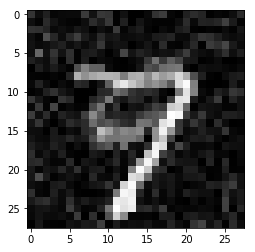

In [96]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')

In [132]:
fmodel = foolbox.models.PyTorchModel(
    net, bounds=(0, 1), num_classes=10, preprocessing=(0, 1))

In [133]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.BoundaryAttack(
    model=fmodel, criterion=criterion, distance=distance)

In [135]:
attack_params = {
    'iterations': 2000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 100,
    'spherical_step': 1.0,
    'source_step': 0.1,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=False, **attack_params)

run with verbose=True to see details
Step 0: 1.70851e-01, stepsizes = 1.0e+00/1.0e-01: 
Step 100: 5.18938e-02, stepsizes = 4.4e-01/4.4e-02:  (took 0.10067 seconds)
Step 200: 2.04484e-02, stepsizes = 2.0e-01/2.0e-02:  (took 0.00762 seconds)
Step 300: 1.32653e-02, stepsizes = 5.9e-02/3.9e-03:  (took 0.00827 seconds)
Step 400: 8.66029e-03, stepsizes = 3.9e-02/1.7e-03: d. reduced by 0.35% (3.0115e-05) (took 0.01879 seconds)
Step 500: 6.75292e-03, stepsizes = 2.6e-02/1.2e-03: d. reduced by 0.23% (1.5641e-05) (took 0.01096 seconds)
Step 600: 5.75658e-03, stepsizes = 2.6e-02/7.7e-04: d. reduced by 0.15% (8.8838e-06) (took 0.00927 seconds)
Step 700: 5.09897e-03, stepsizes = 1.7e-02/5.1e-04: d. reduced by 0.10% (5.2439e-06) (took 0.01148 seconds)
Step 800: 4.72065e-03, stepsizes = 1.2e-02/3.4e-04:  (took 0.01006 seconds)
Step 900: 4.54329e-03, stepsizes = 1.2e-02/3.4e-04: d. reduced by 0.07% (3.1142e-06) (took 0.00837 seconds)
Step 1000: 4.32558e-03, stepsizes = 7.7e-03/2.3e-04: d. reduced by 0

In [136]:
y_pred = net(torch.tensor(x_adv).cuda())
print((y_pred.argmax(1).cpu().detach() == y_test[:num]).sum() / num)

tensor(1)


In [137]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

1.7548374


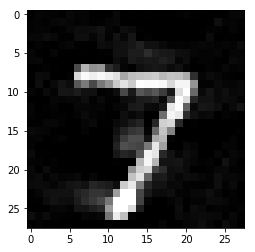

In [103]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')

In [141]:
criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.LBFGSAttack(approximate_gradient=True)

In [ ]:
num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
#     adv = foolbox.adversarial.Adversarial(
#         fmodel, criterion, x_test[i].numpy(), y_test[i].numpy(), 
#         distance=distance, verbose=True)
    adv = foolbox.adversarial.Adversarial(
        dknn_fb, criterion, x_test[i].numpy(), y_test[i].numpy(), 
        distance=distance, verbose=True)
    x_adv[i] = attack(adv, unpack=True, epsilon=1e-05, num_random_targets=0, maxiter=150)

In [143]:
y_pred = net(torch.tensor(x_adv).cuda())
print((y_pred.argmax(1).cpu().detach() == y_test[:num]).sum() / num)

tensor(0)


In [144]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

nan


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked eleme

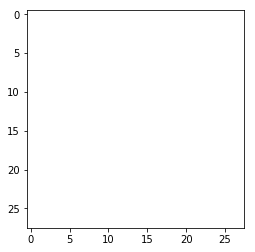

In [145]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')